In [13]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry


In [14]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client()


# url = "https://api.open-meteo.com/v1/forecast" 		----- FOR FORECASTING
url = "https://archive-api.open-meteo.com/v1/archive" # ----- ARCHIVE DATA


params = {
	"latitude": -74.0411, # North Pole
	"longitude": 51.4071, # North Pole
	"start_date": "2021-07-01",
	"end_date": "2021-07-10",
	"hourly": ["temperature_2m", "relative_humidity_2m", "surface_pressure", "wind_speed_10m", "wind_direction_10m"], # Our params
	"timeformat": "unixtime"
}

responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
# print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
# print(f"Elevation {response.Elevation()} m asl")
# print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
# print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

hourly = response.Hourly()
hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
# Process hourly data. The order of variables needs to be the same as requested.
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["hourly_wind_direction_10m"] = hourly_wind_direction_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe

,date,temperature_2m,relative_humidity_2m,surface_pressure,wind_speed_10m,hourly_wind_direction_10m
0,2021-07-01 00:00:00+00:00,-55.943501,63.008278,624.190918,26.081993,206.211319
1,2021-07-01 01:00:00+00:00,-56.193501,62.130650,624.546509,25.318008,209.845840
2,2021-07-01 02:00:00+00:00,-56.393501,61.670197,624.780396,25.762016,213.023880
3,2021-07-01 03:00:00+00:00,-56.493500,61.243488,624.772888,26.758923,213.476303
4,2021-07-01 04:00:00+00:00,-56.493500,61.637867,624.834961,26.980793,211.357025
...,...,...,...,...,...,...
235,2021-07-10 19:00:00+00:00,-48.093498,64.230606,631.609497,23.584808,148.736328
236,2021-07-10 20:00:00+00:00,-48.043499,64.245338,632.049988,23.966375,147.264786
237,2021-07-10 21:00:00+00:00,-48.143501,64.973602,632.178772,24.363249,145.840256
238,2021-07-10 22:00:00+00:00,-47.493500,66.695374,633.361206,23.904108,142.957443


<Axes: xlabel='date'>

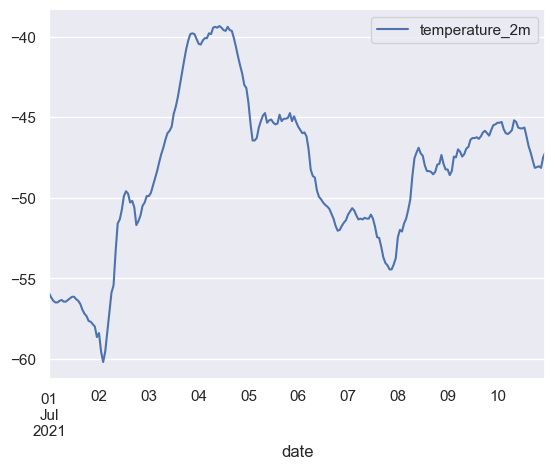

In [15]:
import seaborn as sns
sns.set_theme()

hourly_dataframe.plot(x="date", y="temperature_2m")